## PersiteWrapper

This is where I develop the `PersiteWrapper` and test if we should use regularization. 
The answer is no. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from netam import framework, models
from netam.common import pick_device
from shmex.shm_data import train_val_dfs_of_nickname
from shmex.shm_zoo import default_burrito_params
from shmex.local import localify

figures_dir = localify('FIGURES_DIR')

device = pick_device()

Using Metal Performance Shaders
Using Metal Performance Shaders


In [2]:
! mkdir -p _ignore/original_shmoof
! curl -o _ignore/original_shmoof/mutabilities_context.tsv https://raw.githubusercontent.com/statbiophys/shmoof/master/mutabilities_context.tsv
! curl -o _ignore/original_shmoof/mutabilities_position.tsv https://raw.githubusercontent.com/statbiophys/shmoof/master/mutabilities_position.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89008  100 89008    0     0   463k      0 --:--:-- --:--:-- --:--:--  462k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9242  100  9242    0     0  37243      0 --:--:-- --:--:-- --:--:-- 37266


In [3]:
kmer_length = 3
site_count = 500
weight_decay = 1e-6

model_params = {
    "kmer_length": kmer_length,
    "kernel_size": 11,
    "embedding_dim": 7,
    "filter_count": 19,
    "dropout_prob": 0.3,
}

train_df, val_df = train_val_dfs_of_nickname('shmoof_small')

train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)

train_dataset.to(device)
val_dataset.to(device)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

Interpreting shmoof_small as a shmoof dataset


we have 46391 training examples and 2625 validation examples


In [4]:
class WrapperHyperparameters:
    def __init__(self, base_model_hyperparameters, site_count):
        self.base_model_hyperparameters = base_model_hyperparameters
        self.site_count = site_count

    def __getitem__(self, key):
        if key in self.base_model_hyperparameters:
            return self.base_model_hyperparameters[key]
        elif hasattr(self, key):
            return getattr(self, key)
        else:
            raise KeyError(f"Key '{key}' not found in hyperparameters.")

    def __str__(self):
        hyperparameters_dict = {key: getattr(self, key) for key in self.__dict__}
        return str(hyperparameters_dict)

class PersiteWrapper(nn.Module):
    """
    This wraps another model, but adds a per-site component.
    """
    def __init__(self, base_model, site_count, penalty_weight=0.0):
        super(PersiteWrapper, self).__init__()
        self.base_model = base_model
        self.site_count = site_count
        self.penalty_weight = penalty_weight
        self.log_site_rates = nn.Embedding(self.site_count, 1)
        self._hyperparameters = WrapperHyperparameters(
            self.base_model.hyperparameters, self.site_count
        )

    def forward(self, encoded_parents, masks, wt_base_modifier):
        base_model_rates = self.base_model(encoded_parents, masks, wt_base_modifier)
        sequence_length = encoded_parents.size(1)
        positions = torch.arange(sequence_length, device=encoded_parents.device)
        log_site_rates = self.log_site_rates(positions).T
        rates = base_model_rates * torch.exp(log_site_rates)
        return rates
    
    def regularization_loss(self):
        reg_loss = torch.sum(self.log_site_rates.weight ** 2)
        reg_loss *= self.penalty_weight
        return reg_loss 

    @property
    def hyperparameters(self):
        return self._hyperparameters

    @property
    def site_rates(self):
        # Convert site log rates to linear space
        return torch.exp(self.log_site_rates.weight).squeeze()


In [5]:
base_model = models.CNNModel(**model_params)
base_model.to(device)

base_burrito = framework.SHMBurrito(train_dataset, val_dataset, base_model, **default_burrito_params)
losses = base_burrito.train(epochs=100)
losses.tail()

Epoch: 100%|██████████| 100/100 [14:21<00:00,  8.62s/it, loss_diff=5.7e-07, lr=3.13e-5, val_loss=0.0555]    


,train_loss,val_loss
95,0.061145,0.055499
96,0.061147,0.055500
97,0.061137,0.055500
98,0.061123,0.055500
99,0.061145,0.055501


In [6]:
base_burrito.save_crepe("_ignore/cnn_lrg")

In [7]:
# Freeze the base model.
base_model.eval()
for param in base_model.parameters():
    param.requires_grad = False

model = PersiteWrapper(base_model, site_count=site_count)
model.to(device)
burrito = framework.SHMBurrito(train_dataset, val_dataset, model, **default_burrito_params)
print("starting training...")
losses = burrito.train(epochs=100)
losses.tail()

starting training...


Epoch: 100%|██████████| 100/100 [11:12<00:00,  6.73s/it, loss_diff=-4.321e-07, lr=0.0005, val_loss=0.05589]


,train_loss,val_loss
95,0.061413,0.055895
96,0.061425,0.055895
97,0.061437,0.055894
98,0.061428,0.055894
99,0.061426,0.055894


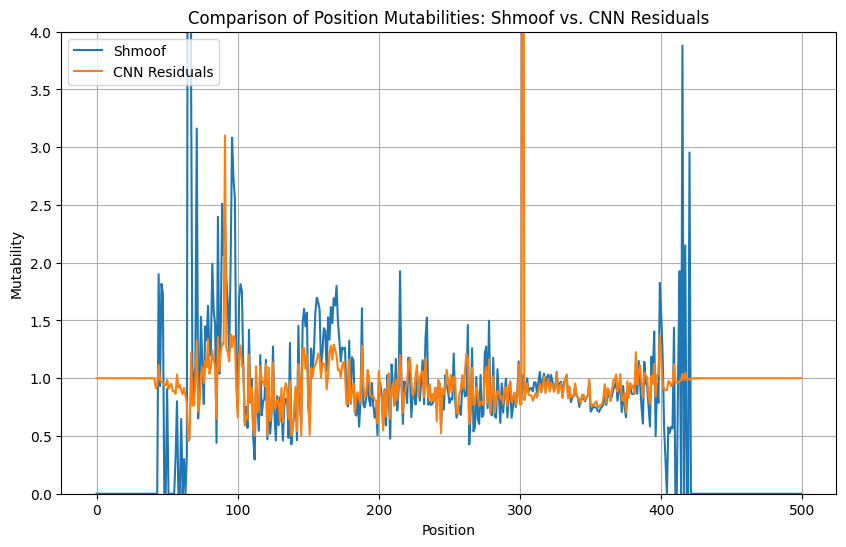

In [8]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
# Move to 0-indexing
shmoof_positions["Position"] -= 1
cnn_residuals = torch.exp(model.log_site_rates.weight).cpu().squeeze().detach().numpy()
cnn_residuals = pd.DataFrame({'Position': np.arange(len(cnn_residuals)), 'Mutability': cnn_residuals})

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, cnn_residuals, on='Position', suffixes=('_shmoof', '_cnn_residuals'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_cnn_residuals'], label='CNN Residuals')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.ylim(0, 4)

plt.title('Comparison of Position Mutabilities: Shmoof vs. CNN Residuals')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
results = []
best_validation_loss = float('inf')

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    base_model = models.CNNModel(**model_params)
    model = PersiteWrapper(base_model, site_count=site_count, penalty_weight=coeff)
    model.to(device)
    burrito = framework.SHMBurrito(train_dataset, val_dataset, model, **default_burrito_params)
    loss_history = burrito.train(epochs=100)
    final_training_loss = loss_history['train_loss'].iloc[-1]
    final_validation_loss = loss_history['val_loss'].iloc[-1]
    if final_validation_loss < best_validation_loss:
        best_validation_loss = final_validation_loss
        best_model = model

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
regularization_results_df

Training with regularization coefficient 0


Epoch: 100%|██████████| 100/100 [12:24<00:00,  7.45s/it, loss_diff=9.47e-06, lr=0.00025, val_loss=0.05551]


Training with regularization coefficient 1e-08


Epoch: 100%|██████████| 100/100 [12:21<00:00,  7.42s/it, loss_diff=-3.517e-06, lr=0.00025, val_loss=0.0555]


Training with regularization coefficient 1e-07


Epoch: 100%|██████████| 100/100 [11:27<00:00,  6.87s/it, loss_diff=7.264e-07, lr=0.0005, val_loss=0.05551]


Training with regularization coefficient 1e-06


Epoch: 100%|██████████| 100/100 [11:34<00:00,  6.95s/it, loss_diff=-1.044e-05, lr=0.00025, val_loss=0.05542]


Training with regularization coefficient 1e-05


Epoch: 100%|██████████| 100/100 [11:08<00:00,  6.68s/it, loss_diff=1.628e-06, lr=0.000125, val_loss=0.05542]


Training with regularization coefficient 0.0001


Epoch: 100%|██████████| 100/100 [11:14<00:00,  6.74s/it, loss_diff=-7.909e-06, lr=0.00025, val_loss=0.05545]


Training with regularization coefficient 0.001


Epoch: 100%|██████████| 100/100 [11:10<00:00,  6.70s/it, loss_diff=-4.257e-05, lr=0.0005, val_loss=0.05551]


Training with regularization coefficient 0.01


Epoch: 100%|██████████| 100/100 [11:00<00:00,  6.61s/it, loss_diff=5.223e-06, lr=0.00025, val_loss=0.05551]


,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.060667,0.055508
1,1.000000e-08,0.060653,0.055498
2,1.000000e-07,0.060634,0.055507
3,1.000000e-06,0.060640,0.055425
4,1.000000e-05,0.060766,0.055423
5,1.000000e-04,0.061009,0.055453
6,1.000000e-03,0.061161,0.055514
7,1.000000e-02,0.061113,0.055509


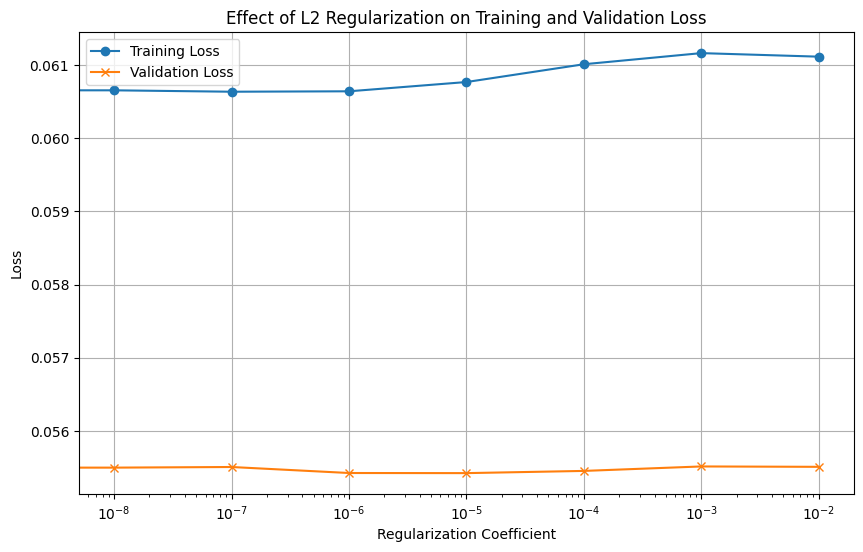

,Regularization,Final_Training_Loss,Final_Validation_Loss
0,0.000000e+00,0.060667,0.055508
1,1.000000e-08,0.060653,0.055498
2,1.000000e-07,0.060634,0.055507
3,1.000000e-06,0.060640,0.055425
4,1.000000e-05,0.060766,0.055423
5,1.000000e-04,0.061009,0.055453
6,1.000000e-03,0.061161,0.055514
7,1.000000e-02,0.061113,0.055509


In [10]:
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

regularization_results_df

Conclusion: don't regularize the site rates, it doesn't help.